In [43]:
import os
from pathlib import Path
import pandas as pd

root_path = Path().resolve().parent

In [44]:
df = pd.read_csv(os.path.join(root_path, 'data', 'csv', 'weatherAUS.csv'))
df = df.rename(columns={'Date': 'date',
                        'Location': 'location',
                        'MinTemp': 'min_temp',
                        'MaxTemp': 'max_temp',
                        'Rainfall': 'rainfall',
                        'Evaporation': 'evaporation',
                        'Sunshine': 'sunshine',
                        'WindGustDir': 'wind_gust_dir',
                        'WindGustSpeed': 'wind_gust_speed',
                        'WindDir9am': 'wind_dir_9am',
                        'WindDir3pm': 'wind_dir_3pm',
                        'WindSpeed9am': 'wind_speed_9am',
                        'WindSpeed3pm': 'wind_speed_3pm',
                        'Humidity9am': 'humidity_9am',
                        'Humidity3pm': 'humidity_3pm',
                        'Pressure9am': 'pressure_9am',
                        'Pressure3pm': 'pressure_3pm',
                        'Cloud9am': 'cloud_9am',
                        'Cloud3pm': 'cloud_3pm',
                        'Temp9am': 'temp_9am',
                        'Temp3pm': 'temp_3pm',
                        'RainToday': 'rain_today',
                        'RainTomorrow': 'rain_tomorrow'})
df = df.loc[(df['location'] == 'Canberra') |
            (df['location'] == 'Sydney') |
            (df['location'] == 'Darwin') |
            (df['location'] == 'Melbourne') |
            (df['location'] == 'Brisbane City')]

In [45]:
df.head()

,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,wind_dir_9am,...,humidity_9am,humidity_3pm,pressure_9am,pressure_3pm,cloud_9am,cloud_3pm,temp_9am,temp_3pm,rain_today,rain_tomorrow
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes


In [46]:
df.shape

(13166, 23)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13166 entries, 30176 to 142303
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             13166 non-null  object 
 1   location         13166 non-null  object 
 2   min_temp         12675 non-null  float64
 3   max_temp         12679 non-null  float64
 4   rainfall         12383 non-null  float64
 5   evaporation      11454 non-null  float64
 6   sunshine         11230 non-null  float64
 7   wind_gust_dir    11729 non-null  object 
 8   wind_gust_speed  11735 non-null  float64
 9   wind_dir_9am     12491 non-null  object 
 10  wind_dir_3pm     12890 non-null  object 
 11  wind_speed_9am   12907 non-null  float64
 12  wind_speed_3pm   12916 non-null  float64
 13  humidity_9am     12605 non-null  float64
 14  humidity_3pm     12652 non-null  float64
 15  pressure_9am     12438 non-null  float64
 16  pressure_3pm     12441 non-null  float64
 17  cloud_9am   

In [48]:
df.describe()

,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_speed,wind_speed_9am,wind_speed_3pm,humidity_9am,humidity_3pm,pressure_9am,pressure_3pm,cloud_9am,cloud_3pm,temp_9am,temp_3pm
count,12675.000000,12679.000000,12383.000000,11454.000000,11230.000000,11735.000000,12907.000000,12916.000000,12605.000000,12652.000000,12438.000000,12441.000000,10491.000000,10231.000000,12662.000000,12669.000000
mean,14.129799,24.377530,3.057498,5.222368,7.358709,42.038517,14.901294,20.333462,69.480444,50.819712,1016.698392,1014.055276,4.616910,4.595445,18.103514,22.895793
std,7.652003,7.093133,10.590969,2.855495,3.716506,13.522773,9.222554,8.346006,15.171432,17.689511,7.211286,7.242959,2.711051,2.620294,7.349728,7.018754
min,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,4.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000
25%,8.900000,18.500000,0.000000,3.000000,4.600000,33.000000,9.000000,15.000000,60.000000,39.000000,1011.800000,1008.700000,2.000000,2.000000,12.400000,17.200000
50%,14.000000,24.200000,0.000000,5.000000,8.300000,39.000000,13.000000,20.000000,71.000000,51.000000,1016.000000,1013.100000,5.000000,5.000000,17.700000,22.600000
75%,20.300000,31.200000,1.000000,7.000000,10.500000,50.000000,20.000000,26.000000,80.000000,62.000000,1021.700000,1019.200000,7.000000,7.000000,24.300000,29.400000
max,29.700000,46.400000,367.600000,23.800000,13.900000,126.000000,67.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,36.500000,45.400000


In [49]:
df.isna().sum()

date                  0
location              0
min_temp            491
max_temp            487
rainfall            783
evaporation        1712
sunshine           1936
wind_gust_dir      1437
wind_gust_speed    1431
wind_dir_9am        675
wind_dir_3pm        276
wind_speed_9am      259
wind_speed_3pm      250
humidity_9am        561
humidity_3pm        514
pressure_9am        728
pressure_3pm        725
cloud_9am          2675
cloud_3pm          2935
temp_9am            504
temp_3pm            497
rain_today          783
rain_tomorrow       784
dtype: int64

In [50]:
df['date'] = pd.to_datetime(df['date'])

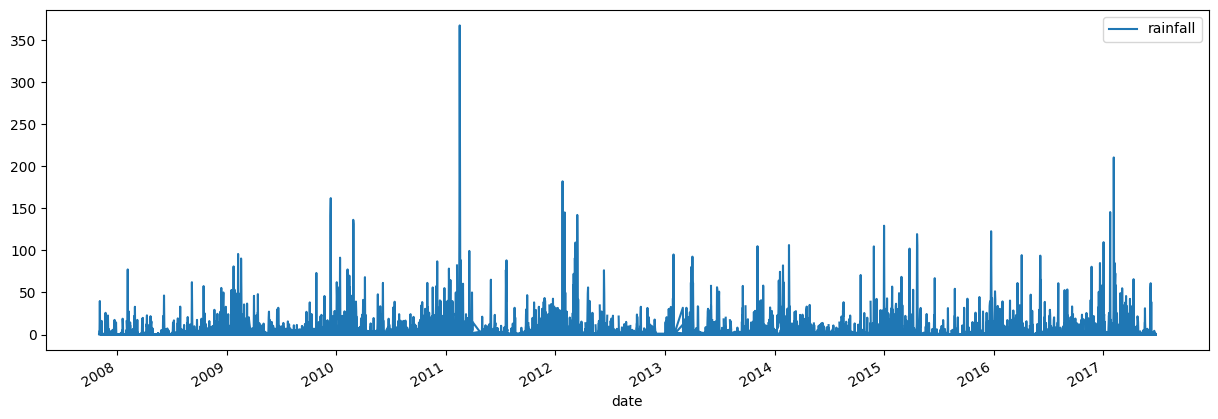

In [51]:
plot = df.plot(x='date', y='rainfall', figsize=(15, 5))

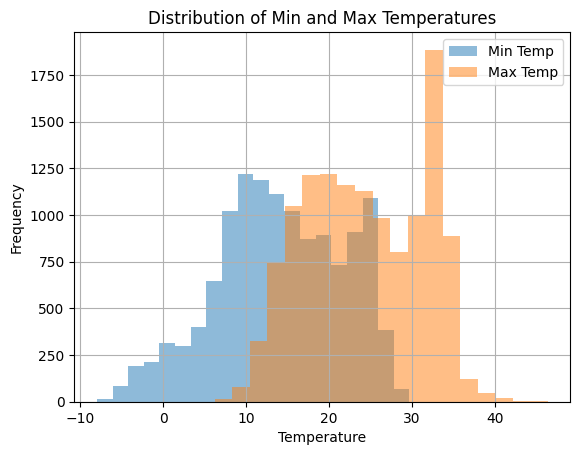

In [52]:
import matplotlib.pyplot as plt

df['min_temp'].hist(bins=20, alpha=0.5, label='Min Temp')
df['max_temp'].hist(bins=20, alpha=0.5, label='Max Temp')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Min and Max Temperatures')
plt.show()

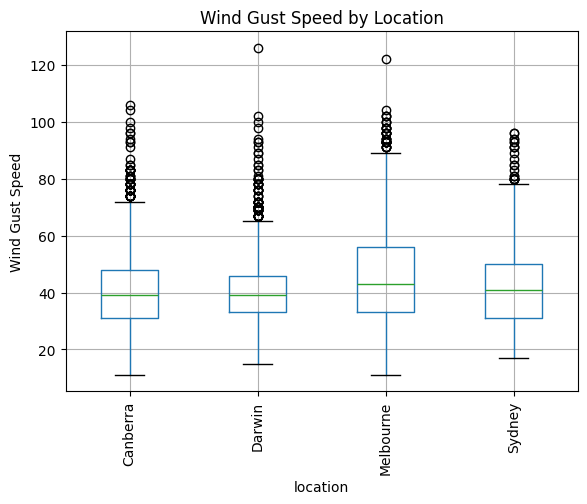

In [53]:
df.boxplot(column='wind_gust_speed', by='location', rot=90)
plt.ylabel('Wind Gust Speed')
plt.title('Wind Gust Speed by Location')
plt.suptitle('')
plt.show()

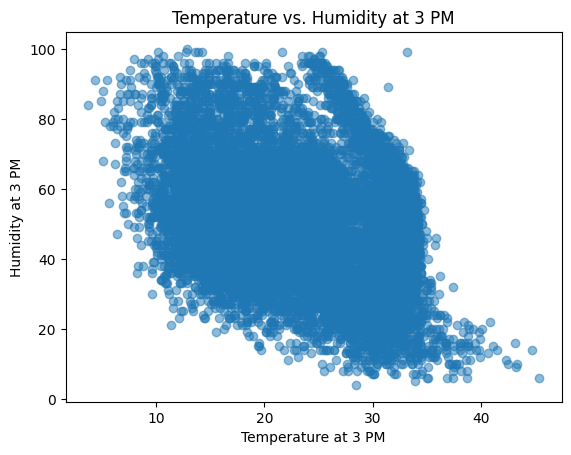

In [54]:
plt.scatter(df['temp_3pm'], df['humidity_3pm'], alpha=0.5)
plt.xlabel('Temperature at 3 PM')
plt.ylabel('Humidity at 3 PM')
plt.title('Temperature vs. Humidity at 3 PM')
plt.show()

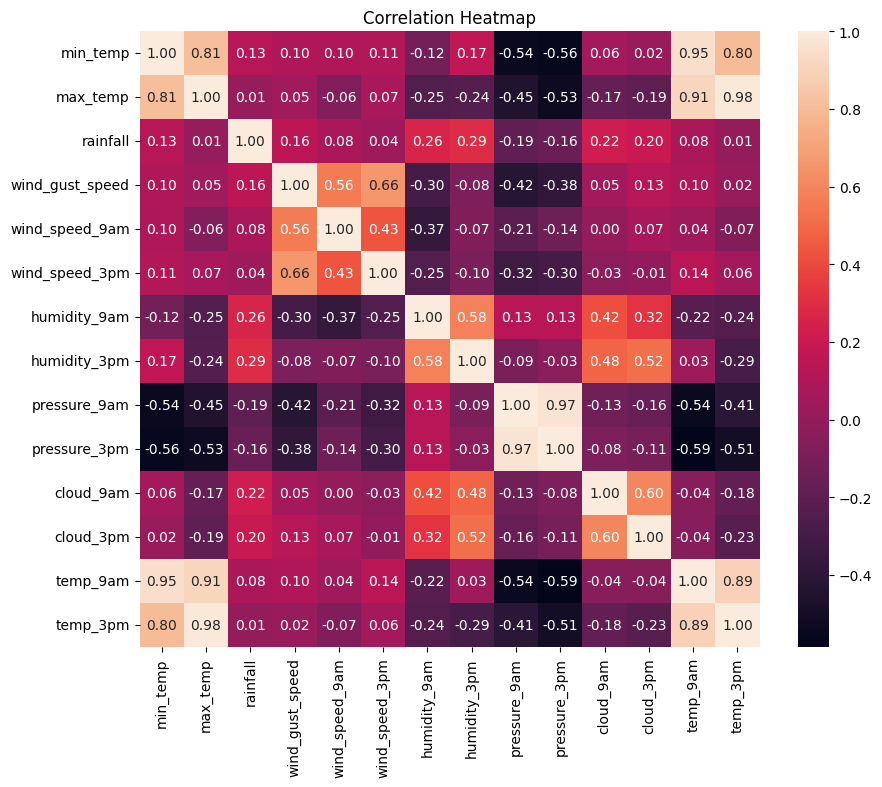

In [55]:
import seaborn as sns

numerical_columns = ['min_temp', 'max_temp', 'rainfall', 'wind_gust_speed',
                     'wind_speed_9am', 'wind_speed_3pm', 'humidity_9am',
                     'humidity_3pm', 'pressure_9am', 'pressure_3pm',
                     'cloud_9am', 'cloud_3pm', 'temp_9am', 'temp_3pm']

corr = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [56]:
df = df.drop(['evaporation', 'sunshine'], axis=1)

In [57]:
df = df.dropna(subset=['rain_tomorrow'])

In [58]:
from sklearn.model_selection import train_test_split

y = df['rain_tomorrow']
X = df.drop(['rain_tomorrow', 'date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

print("Train Set:", X_train.shape)
print("Test Set:", X_test.shape)

Train Set: (9905, 19)
Test Set: (2477, 19)


In [59]:
numerical_columns = ['min_temp', 'max_temp', 'rainfall', 'wind_gust_speed',
                     'wind_speed_9am', 'wind_speed_3pm', 'humidity_9am',
                     'humidity_3pm', 'pressure_9am', 'pressure_3pm',
                     'cloud_9am', 'cloud_3pm', 'temp_9am', 'temp_3pm']

for col in numerical_columns:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_test[col].median())


categorical_columns = ['location', 'wind_gust_dir', 'wind_dir_9am', 'wind_dir_3pm', 'rain_today']

for col in categorical_columns:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

In [60]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [71]:
def encode_categorical(data, column):
    unique_elements = sorted(data[column].unique())
    mapping = {element: index for index, element in enumerate(unique_elements)}
    data[column] = data[column].map(mapping)
    return data[column], mapping

X_train['location'], location_mapping_train = encode_categorical(X_train, 'location')
X_train['rain_today'], rain_mapping_train = encode_categorical(X_train, 'rain_today')
X_train = pd.get_dummies(X_train, dtype=int)

X_test['location'], location_mapping_test = encode_categorical(X_test, 'location')
X_test['rain_today'], rain_mapping_test = encode_categorical(X_test, 'rain_today')
X_test = pd.get_dummies(X_test, dtype=int)

In [62]:
X_train.head()

,location,min_temp,max_temp,rainfall,wind_gust_speed,wind_speed_9am,wind_speed_3pm,humidity_9am,humidity_3pm,pressure_9am,...,wind_dir_3pm_NNW,wind_dir_3pm_NW,wind_dir_3pm_S,wind_dir_3pm_SE,wind_dir_3pm_SSE,wind_dir_3pm_SSW,wind_dir_3pm_SW,wind_dir_3pm_W,wind_dir_3pm_WNW,wind_dir_3pm_WSW
0,1,22.8,31.8,0.0,30.0,11.0,22.0,69.0,60.0,1015.7,...,0,0,0,0,0,0,0,0,0,0
1,3,10.1,15.4,7.8,39.0,11.0,9.0,95.0,85.0,1030.0,...,0,0,0,0,0,0,0,0,0,0
2,0,3.3,21.4,0.0,28.0,7.0,15.0,73.0,35.0,1028.9,...,0,0,0,0,0,0,0,0,0,0
3,3,14.7,17.9,12.6,39.0,6.0,22.0,90.0,89.0,1024.0,...,0,0,0,0,1,0,0,0,0,0
4,0,15.3,33.2,0.0,44.0,4.0,24.0,60.0,18.0,1013.9,...,0,1,0,0,0,0,0,0,0,0


In [63]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train_scaled = scaler_train.transform(X_train)

scaler_test = StandardScaler()
scaler_test.fit(X_test)
X_test_scaled = scaler_test.transform(X_test)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

cl1 = LogisticRegression()
cl1.fit(X_train_scaled, y_train)
print("Accuracy score LogisticRegression: ",
      cl1.score(X_test_scaled, y_test))

cl2 = DecisionTreeClassifier()
cl2.fit(X_train_scaled, y_train)
print("Accuracy score DecisionTreeClassifier: ",
      cl2.score(X_test_scaled, y_test))

cl3 = RandomForestClassifier()
cl3.fit(X_train_scaled, y_train)
print("Accuracy score RandomForestClassifier: ",
      cl3.score(X_test_scaled, y_test))

Accuracy score LogisticRegression:  0.8433589018974565
Accuracy score DecisionTreeClassifier:  0.7666532095276544
Accuracy score RandomForestClassifier:  0.8433589018974565


In [65]:
from sklearn.metrics import classification_report

y_pred_test = cl3.predict(X_test_scaled)

display(pd.crosstab(y_pred_test, y_test, colnames =  ['real cases'], rownames = ['predicted cases']))

classification_report(y_test, y_pred_test)

real cases,No,Yes
predicted cases,,
No,1789,296
Yes,92,300


'              precision    recall  f1-score   support\n\n          No       0.86      0.95      0.90      1881\n         Yes       0.77      0.50      0.61       596\n\n    accuracy                           0.84      2477\n   macro avg       0.81      0.73      0.75      2477\nweighted avg       0.84      0.84      0.83      2477\n'

In [66]:
cl3.score(X_train_scaled, y_train)

1.0

In [67]:
from joblib import dump

dump(cl3, os.path.join(root_path, 'data', 'model', 'random_forest.joblib'))

['/Users/tanguyboulard/Programmation/DataScientest-project-DEC23/data/model/random_forest.joblib']

In [68]:
from joblib import load

model = load(os.path.join(root_path, 'data', 'model', 'random_forest.joblib'))

In [69]:
new_data = pd.DataFrame({
    'date': ['2021-01-01'],
    'location': ['Brisbane City'],
    'min_temp': [12.5],
    'max_temp': [25.5],
    'evaporation': [0.0],
    'sunshine': [0.0],
    'rainfall': [0.0],
    'wind_gust_dir': ['W'],
    'wind_gust_speed': [30],
    'wind_dir_9am': ['W'],
    'wind_speed_9am': [15],
    'wind_dir_3pm': ['W'],
    'wind_speed_3pm': [20],
    'humidity_9am': [50],
    'humidity_3pm': [60],
    'pressure_9am': [1010],
    'pressure_3pm': [1005],
    'cloud_9am': [5],
    'cloud_3pm': [5],
    'temp_9am': [20],
    'temp_3pm': [23],
    'rain_today': ['No']
})
new_data

,date,location,min_temp,max_temp,evaporation,sunshine,rainfall,wind_gust_dir,wind_gust_speed,wind_dir_9am,...,wind_speed_3pm,humidity_9am,humidity_3pm,pressure_9am,pressure_3pm,cloud_9am,cloud_3pm,temp_9am,temp_3pm,rain_today
0,2021-01-01,Brisbane City,12.5,25.5,0.0,0.0,0.0,W,30,W,...,20,50,60,1010,1005,5,5,20,23,No


In [72]:
def process_new_data(new_data):    
    scaler = scaler_test
    
    new_data = new_data.drop(['date', 'evaporation', 'sunshine'], axis=1)
    
    new_data['location'] = new_data['location'].map(location_mapping_test)
    new_data['rain_today'] = new_data['rain_today'].map(rain_mapping_test)
    
    new_data = pd.get_dummies(new_data, dtype=int)
    
    # Ensure all expected columns are present
    missing_cols = set(X_test.columns) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0
    
    # Reorder columns to match the training set
    new_data = new_data[X_test.columns]
    
    new_data_scaled = scaler.transform(new_data)
    
    return new_data_scaled

processed_new_data = process_new_data(new_data)
model.predict(processed_new_data)[0]

'No'